In [1]:
# Install required packages
%pip install transformers datasets accelerate scikit-learn

Note: you may need to restart the kernel to use updated packages.


## BERT Baseline for GoEmotions Classification (27 Labels)
This notebook trains a baseline BERT model on the GoEmotions dataset with all 27 original emotion labels.

In [2]:
#check if cuda is available
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

Using GPU: NVIDIA GeForce RTX 4080 SUPER


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/xiang/miniconda3/envs/nlp/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Load and Prepare Data

In [4]:
from datasets import load_dataset

# Load the GoEmotions dataset from Hugging Face
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

# Define all 27 GoEmotions labels (+ neutral = 28, but the dataset has 27 unique emotions)
LABELS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]
NUM_LABELS = len(LABELS)

# Convert dataset to DataFrames
def convert_to_df(split):
    data = dataset[split]
    rows = []
    for i in range(len(data)):
        text = data[i]['text']
        label_ids = data[i]['labels']
        # Create multi-hot encoding
        label_vec = [1 if j in label_ids else 0 for j in range(NUM_LABELS)]
        rows.append([text] + label_vec)
    return pd.DataFrame(rows, columns=['text'] + LABELS)

train_df = convert_to_df('train')
val_df = convert_to_df('validation')
test_df = convert_to_df('test')

print(f"Dataset sizes - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"\nNumber of labels: {NUM_LABELS}")
print(f"Labels: {LABELS}")

print("\nLabel distribution in training set:")
for label in LABELS:
    count = train_df[label].sum()
    pct = count / len(train_df) * 100
    print(f"  {label}: {count} ({pct:.1f}%)")

Dataset sizes - Train: 43410, Val: 5426, Test: 5427

Number of labels: 28
Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

Label distribution in training set:
  admiration: 4130 (9.5%)
  amusement: 2328 (5.4%)
  anger: 1567 (3.6%)
  annoyance: 2470 (5.7%)
  approval: 2939 (6.8%)
  caring: 1087 (2.5%)
  confusion: 1368 (3.2%)
  curiosity: 2191 (5.0%)
  desire: 641 (1.5%)
  disappointment: 1269 (2.9%)
  disapproval: 2022 (4.7%)
  disgust: 793 (1.8%)
  embarrassment: 303 (0.7%)
  excitement: 853 (2.0%)
  fear: 596 (1.4%)
  gratitude: 2662 (6.1%)
  grief: 77 (0.2%)
  joy: 1452 (3.3%)
  love: 2086 (4.8%)
  nervousness: 164 (0.4%)
  optimism: 1581 (3.6%)
  pride: 111 (0.3%)
  realization: 1110 (2.6%)
  

### Create Dataset Class and DataLoaders

In [5]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = LABELS
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = str(self.data.loc[idx, 'text'])
        labels = self.data.loc[idx, self.labels].values.astype(float)
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

# Create dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 2714
Validation batches: 340
Test batches: 340


### Initialize Model

In [6]:
# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)
model.to(device)

# Setup optimizer and scheduler
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Model loaded on {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda


### Training and Evaluation Functions

In [7]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            # Apply sigmoid and threshold
            probs = torch.sigmoid(outputs.logits)
            preds = (probs > threshold).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return {
        'loss': total_loss / len(dataloader),
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'predictions': all_preds,
        'labels': all_labels
    }

### Train the Model

In [8]:
# Training loop
best_f1 = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    # Evaluate on validation set
    val_results = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_results['loss']:.4f}")
    print(f"Validation F1 (micro): {val_results['f1_micro']:.4f}")
    print(f"Validation F1 (macro): {val_results['f1_macro']:.4f}")
    
    # Save best model
    if val_results['f1_macro'] > best_f1:
        best_f1 = val_results['f1_macro']
        torch.save(model.state_dict(), 'best_bert_model.pt')
        print("Saved best model!")

print(f"\nBest Validation F1 (macro): {best_f1:.4f}")


Epoch 1/3


Training: 100%|██████████| 2714/2714 [03:28<00:00, 13.00it/s]


Training Loss: 0.1236


Evaluating: 100%|██████████| 340/340 [00:12<00:00, 27.98it/s]


Validation Loss: 0.0911
Validation F1 (micro): 0.5296
Validation F1 (macro): 0.2653
Saved best model!

Epoch 2/3


Training: 100%|██████████| 2714/2714 [03:28<00:00, 13.02it/s]


Training Loss: 0.0840


Evaluating: 100%|██████████| 340/340 [00:09<00:00, 37.23it/s]


Validation Loss: 0.0851
Validation F1 (micro): 0.5704
Validation F1 (macro): 0.3893
Saved best model!

Epoch 3/3


Training: 100%|██████████| 2714/2714 [03:19<00:00, 13.57it/s]


Training Loss: 0.0729


Evaluating: 100%|██████████| 340/340 [00:08<00:00, 38.14it/s]


Validation Loss: 0.0850
Validation F1 (micro): 0.5727
Validation F1 (macro): 0.4067
Saved best model!

Best Validation F1 (macro): 0.4067


### Evaluate on Test Set

In [9]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_bert_model.pt'))

test_results = evaluate(model, test_loader, device)

print("="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test F1 (micro): {test_results['f1_micro']:.4f}")
print(f"Test F1 (macro): {test_results['f1_macro']:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(
    test_results['labels'], 
    test_results['predictions'], 
    target_names=LABELS,
    zero_division=0
))

Evaluating: 100%|██████████| 340/340 [00:10<00:00, 32.45it/s]

TEST SET RESULTS
Test Loss: 0.0837
Test F1 (micro): 0.5882
Test F1 (macro): 0.4269

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.72      0.72      0.72       504
     amusement       0.80      0.84      0.82       264
         anger       0.60      0.40      0.48       198
     annoyance       0.59      0.16      0.25       320
      approval       0.65      0.30      0.41       351
        caring       0.57      0.32      0.41       135
     confusion       0.64      0.28      0.39       153
     curiosity       0.54      0.50      0.52       284
        desire       0.76      0.34      0.47        83
disappointment       0.76      0.09      0.15       151
   disapproval       0.50      0.28      0.36       267
       disgust       0.82      0.30      0.44       123
 embarrassment       0.00      0.00      0.00        37
    excitement       0.71      0.28      0.40       103
          fear       0.77      0.62      0.

### Test with Sample Predictions

In [10]:
def predict_emotions(text, model, tokenizer, threshold=0.3):
    """Predict emotions for a single text."""
    model.eval()
    
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    
    with torch.no_grad():
        outputs = model(
            input_ids=encoding['input_ids'].to(device),
            attention_mask=encoding['attention_mask'].to(device)
        )
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]
    
    results = {label: prob for label, prob in zip(LABELS, probs)}
    predicted = [label for label, prob in results.items() if prob > threshold]
    
    return results, predicted

# Test with sample texts
sample_texts = [
    "I'm so happy today! Everything is going great!",
    "This makes me so angry, I can't believe it!",
    "I'm really scared about what might happen.",
    "That's disgusting, I hate it.",
    "I feel so sad and lonely.",
    "Wow, I didn't expect that at all!",
    "Thank you so much, you're amazing!",
    "I'm curious about how this works.",
    "I love you so much!"
]

print("Sample Predictions:")
print("="*60)
for text in sample_texts:
    probs, predicted = predict_emotions(text, model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted: {predicted if predicted else ['neutral']}")
    # Only show top 5 emotions by probability
    top_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Top 5 Probabilities: {', '.join([f'{k}:{v:.2f}' for k, v in top_probs])}")

Sample Predictions:

Text: I'm so happy today! Everything is going great!
Predicted: ['joy']
Top 5 Probabilities: joy:0.82, admiration:0.27, excitement:0.12, approval:0.04, gratitude:0.04

Text: This makes me so angry, I can't believe it!
Predicted: ['anger']
Top 5 Probabilities: anger:0.80, annoyance:0.26, disgust:0.05, neutral:0.02, surprise:0.02

Text: I'm really scared about what might happen.
Predicted: ['fear']
Top 5 Probabilities: fear:0.72, nervousness:0.08, surprise:0.06, disgust:0.05, optimism:0.05

Text: That's disgusting, I hate it.
Predicted: ['disgust']
Top 5 Probabilities: disgust:0.64, anger:0.16, annoyance:0.12, fear:0.09, disapproval:0.08

Text: I feel so sad and lonely.
Predicted: ['sadness']
Top 5 Probabilities: sadness:0.88, disappointment:0.10, remorse:0.04, neutral:0.03, fear:0.03

Text: Wow, I didn't expect that at all!
Predicted: ['surprise']
Top 5 Probabilities: surprise:0.80, excitement:0.06, realization:0.06, neutral:0.05, admiration:0.03

Text: Thank you so

---
## Hyperparameter Tuning for BERT Model Optimization

This section uses Optuna to find optimal hyperparameters for the BERT model. We'll tune:
- Learning rate
- Batch size
- Number of epochs
- Warmup ratio
- Weight decay
- Dropout rate

Then compare the tuned model with the baseline.

In [11]:
# Install Optuna for hyperparameter tuning
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.2/660.2 kB 3.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [optuna]2m5/6 [optuna]]my]
Note: you may need to restart the kernel to use updated packages.


In [12]:
import optuna
from optuna.trial import TrialState
import gc

# Store baseline results for comparison
baseline_results = {
    'model_name': 'Baseline BERT',
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'warmup_steps': 0,
    'weight_decay': 0.0,
    'test_f1_micro': test_results['f1_micro'],
    'test_f1_macro': test_results['f1_macro'],
    'test_loss': test_results['loss']
}

print("Baseline Model Results (for comparison):")
print(f"  Learning Rate: {baseline_results['learning_rate']}")
print(f"  Batch Size: {baseline_results['batch_size']}")
print(f"  Epochs: {baseline_results['epochs']}")
print(f"  Test F1 (micro): {baseline_results['test_f1_micro']:.4f}")
print(f"  Test F1 (macro): {baseline_results['test_f1_macro']:.4f}")

Baseline Model Results (for comparison):
  Learning Rate: 2e-05
  Batch Size: 16
  Epochs: 3
  Test F1 (micro): 0.5882
  Test F1 (macro): 0.4269


### Define Optuna Objective Function
The objective function trains a BERT model with suggested hyperparameters and returns the validation F1 score.

In [13]:
def create_model_with_dropout(dropout_rate):
    """Create a BERT model with custom dropout rate."""
    from transformers import BertConfig
    
    config = BertConfig.from_pretrained(
        'bert-base-uncased',
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification",
        hidden_dropout_prob=dropout_rate,
        attention_probs_dropout_prob=dropout_rate
    )
    
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        config=config
    )
    return model

def objective(trial):
    """Optuna objective function for hyperparameter tuning."""
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    epochs = trial.suggest_int('epochs', 2, 5)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.0, 0.2)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    
    # Create dataloaders with suggested batch size
    train_loader_tuned = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_tuned = DataLoader(val_dataset, batch_size=batch_size)
    
    # Create model with suggested dropout
    model = create_model_with_dropout(dropout_rate)
    model.to(device)
    
    # Setup optimizer with weight decay
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Calculate total steps and warmup steps
    total_steps = len(train_loader_tuned) * epochs
    warmup_steps = int(total_steps * warmup_ratio)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Training loop
    best_val_f1 = 0
    
    for epoch in range(epochs):
        # Train
        model.train()
        for batch in tqdm(train_loader_tuned, desc=f"Trial {trial.number} - Epoch {epoch+1}", leave=False):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        # Validate
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader_tuned:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                probs = torch.sigmoid(outputs.logits)
                preds = (probs > 0.5).float()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_f1_macro = f1_score(all_labels, all_preds, average='macro')
        
        if val_f1_macro > best_val_f1:
            best_val_f1 = val_f1_macro
            # Save best model for this trial
            torch.save(model.state_dict(), f'trial_{trial.number}_best.pt')
        
        # Report intermediate value for pruning
        trial.report(val_f1_macro, epoch)
        
        # Handle pruning based on intermediate values
        if trial.should_prune():
            # Clean up
            del model
            gc.collect()
            torch.cuda.empty_cache()
            raise optuna.TrialPruned()
    
    # Clean up
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_val_f1

print("Objective function defined successfully!")

Objective function defined successfully!


### Run Hyperparameter Optimization
This will run multiple trials to find the best hyperparameters. Adjust `n_trials` based on available compute time.

In [14]:
# Create an Optuna study with MedianPruner for early stopping of unpromising trials
study = optuna.create_study(
    direction='maximize',  # Maximize F1 score
    study_name='bert_goemotions_tuning',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1)
)

# Number of trials to run (increase for better results, but takes longer)
N_TRIALS = 10  # Adjust based on available compute time

print(f"Starting hyperparameter optimization with {N_TRIALS} trials...")
print("This may take a while depending on your hardware.\n")

study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION COMPLETE")
print("="*60)

[I 2025-12-17 11:20:36,306] A new study created in memory with name: bert_goemotions_tuning


Starting hyperparameter optimization with 10 trials...
This may take a while depending on your hardware.



  0%|          | 0/10 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Best trial: 0. Best value: 0.171071:  10%|█         | 1/10 [05:45<51:46, 345.14s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 11:26:21,448] Trial 0 finished with value: 0.17107094677635257 and parameters: {'learning_rate': 3.5061521427041676e-05, 'batch_size': 32, 'epochs': 2, 'warmup_ratio': 0.12336113308371806, 'weight_decay': 0.07090580753340105, 'dropout_rate': 0.28180724442495947}. Best is trial 0 with value: 0.17107094677635257.


Best trial: 1. Best value: 0.42919:  20%|██        | 2/10 [22:02<1:35:37, 717.16s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 11:42:39,026] Trial 1 finished with value: 0.4291903651845447 and parameters: {'learning_rate': 2.017382854245565e-05, 'batch_size': 16, 'epochs': 5, 'warmup_ratio': 0.11480229468645634, 'weight_decay': 0.06272172962238025, 'dropout_rate': 0.2610203376005039}. Best is trial 1 with value: 0.4291903651845447.


Best trial: 2. Best value: 0.453649:  30%|███       | 3/10 [34:38<1:25:42, 734.68s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 11:55:14,549] Trial 2 finished with value: 0.45364851940344014 and parameters: {'learning_rate': 4.004925833685487e-05, 'batch_size': 32, 'epochs': 5, 'warmup_ratio': 0.13083548500604622, 'weight_decay': 0.09383228496846313, 'dropout_rate': 0.1850068410932365}. Best is trial 2 with value: 0.45364851940344014.


Best trial: 2. Best value: 0.453649:  40%|████      | 4/10 [40:50<59:10, 591.71s/it]  Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 12:01:27,074] Trial 3 pruned. 


Best trial: 4. Best value: 0.470787:  50%|█████     | 5/10 [57:03<1:00:45, 729.13s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 12:17:39,876] Trial 4 finished with value: 0.4707874428934819 and parameters: {'learning_rate': 4.892555662298133e-05, 'batch_size': 16, 'epochs': 5, 'warmup_ratio': 0.16554719818529223, 'weight_decay': 0.03480486066051946, 'dropout_rate': 0.24407195132826082}. Best is trial 4 with value: 0.4707874428934819.


Best trial: 4. Best value: 0.470787:  60%|██████    | 6/10 [1:03:51<41:19, 619.78s/it]  Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 12:24:27,399] Trial 5 pruned. 


Best trial: 4. Best value: 0.470787:  70%|███████   | 7/10 [1:09:05<25:59, 519.89s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 12:29:41,614] Trial 6 pruned. 


Best trial: 4. Best value: 0.470787:  80%|████████  | 8/10 [1:19:49<18:39, 559.55s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 12:40:26,097] Trial 7 pruned. 


Best trial: 4. Best value: 0.470787:  90%|█████████ | 9/10 [1:27:54<08:56, 536.08s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2025-12-17 12:48:30,574] Trial 8 pruned. 


Best trial: 4. Best value: 0.470787: 100%|██████████| 10/10 [1:33:10<00:00, 559.07s/it]

[I 2025-12-17 12:53:47,051] Trial 9 pruned. 

HYPERPARAMETER OPTIMIZATION COMPLETE


### View Best Hyperparameters

In [15]:
# Display optimization results
print("Best Trial:")
print(f"  Trial Number: {study.best_trial.number}")
print(f"  Best Validation F1 (macro): {study.best_trial.value:.4f}")

print("\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Show all completed trials
print("\n" + "="*60)
print("ALL TRIAL RESULTS")
print("="*60)

completed_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
completed_trials.sort(key=lambda t: t.value, reverse=True)

for i, trial in enumerate(completed_trials[:10]):  # Show top 10
    print(f"\n#{i+1} - Trial {trial.number} (F1: {trial.value:.4f})")
    for key, value in trial.params.items():
        if isinstance(value, float):
            print(f"     {key}: {value:.6f}")
        else:
            print(f"     {key}: {value}")

Best Trial:
  Trial Number: 4
  Best Validation F1 (macro): 0.4708

Best Hyperparameters:
  learning_rate: 4.892555662298133e-05
  batch_size: 16
  epochs: 5
  warmup_ratio: 0.16554719818529223
  weight_decay: 0.03480486066051946
  dropout_rate: 0.24407195132826082

ALL TRIAL RESULTS

#1 - Trial 4 (F1: 0.4708)
     learning_rate: 0.000049
     batch_size: 16
     epochs: 5
     warmup_ratio: 0.165547
     weight_decay: 0.034805
     dropout_rate: 0.244072

#2 - Trial 2 (F1: 0.4536)
     learning_rate: 0.000040
     batch_size: 32
     epochs: 5
     warmup_ratio: 0.130835
     weight_decay: 0.093832
     dropout_rate: 0.185007

#3 - Trial 1 (F1: 0.4292)
     learning_rate: 0.000020
     batch_size: 16
     epochs: 5
     warmup_ratio: 0.114802
     weight_decay: 0.062722
     dropout_rate: 0.261020

#4 - Trial 0 (F1: 0.1711)
     learning_rate: 0.000035
     batch_size: 32
     epochs: 2
     warmup_ratio: 0.123361
     weight_decay: 0.070906
     dropout_rate: 0.281807


### Train Final Optimized Model with Best Hyperparameters
Now we'll train a fresh model using the best hyperparameters found and evaluate it on the test set.

In [16]:
# Extract best hyperparameters
best_params = study.best_trial.params
best_lr = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']
best_warmup_ratio = best_params['warmup_ratio']
best_weight_decay = best_params['weight_decay']
best_dropout = best_params['dropout_rate']

print("Training final model with optimal hyperparameters:")
print(f"  Learning Rate: {best_lr:.6f}")
print(f"  Batch Size: {best_batch_size}")
print(f"  Epochs: {best_epochs}")
print(f"  Warmup Ratio: {best_warmup_ratio:.4f}")
print(f"  Weight Decay: {best_weight_decay:.4f}")
print(f"  Dropout Rate: {best_dropout:.4f}")

# Create dataloaders with best batch size
train_loader_best = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader_best = DataLoader(val_dataset, batch_size=best_batch_size)
test_loader_best = DataLoader(test_dataset, batch_size=best_batch_size)

# Create model with best dropout
tuned_model = create_model_with_dropout(best_dropout)
tuned_model.to(device)

# Setup optimizer
tuned_optimizer = AdamW(tuned_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Calculate steps
total_steps = len(train_loader_best) * best_epochs
warmup_steps = int(total_steps * best_warmup_ratio)

tuned_scheduler = get_linear_schedule_with_warmup(
    tuned_optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training loop for the tuned model
best_tuned_f1 = 0

for epoch in range(best_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{best_epochs}")
    print(f"{'='*50}")
    
    # Train
    train_loss = train_epoch(tuned_model, train_loader_best, tuned_optimizer, tuned_scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    # Evaluate on validation set
    val_results = evaluate(tuned_model, val_loader_best, device)
    print(f"Validation Loss: {val_results['loss']:.4f}")
    print(f"Validation F1 (micro): {val_results['f1_micro']:.4f}")
    print(f"Validation F1 (macro): {val_results['f1_macro']:.4f}")
    
    # Save best model
    if val_results['f1_macro'] > best_tuned_f1:
        best_tuned_f1 = val_results['f1_macro']
        torch.save(tuned_model.state_dict(), 'best_tuned_bert_model.pt')
        print("Saved best tuned model!")

print(f"\nBest Tuned Validation F1 (macro): {best_tuned_f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training final model with optimal hyperparameters:
  Learning Rate: 0.000049
  Batch Size: 16
  Epochs: 5
  Warmup Ratio: 0.1655
  Weight Decay: 0.0348
  Dropout Rate: 0.2441

Epoch 1/5


Training: 100%|██████████| 2714/2714 [03:13<00:00, 14.05it/s]


Training Loss: 0.1816


Evaluating: 100%|██████████| 340/340 [00:12<00:00, 27.82it/s]


Validation Loss: 0.1002
Validation F1 (micro): 0.4488
Validation F1 (macro): 0.2262
Saved best tuned model!

Epoch 2/5


Training: 100%|██████████| 2714/2714 [03:18<00:00, 13.66it/s]


Training Loss: 0.0921


Evaluating: 100%|██████████| 340/340 [00:11<00:00, 28.38it/s]


Validation Loss: 0.0868
Validation F1 (micro): 0.5674
Validation F1 (macro): 0.3963
Saved best tuned model!

Epoch 3/5


Training: 100%|██████████| 2714/2714 [03:13<00:00, 14.05it/s]


Training Loss: 0.0794


Evaluating: 100%|██████████| 340/340 [00:09<00:00, 37.50it/s]


Validation Loss: 0.0853
Validation F1 (micro): 0.5783
Validation F1 (macro): 0.4470
Saved best tuned model!

Epoch 4/5


Training: 100%|██████████| 2714/2714 [03:20<00:00, 13.51it/s]


Training Loss: 0.0703


Evaluating: 100%|██████████| 340/340 [00:10<00:00, 32.31it/s]


Validation Loss: 0.0862
Validation F1 (micro): 0.5785
Validation F1 (macro): 0.4637
Saved best tuned model!

Epoch 5/5


Training: 100%|██████████| 2714/2714 [03:10<00:00, 14.24it/s]


Training Loss: 0.0624


Evaluating: 100%|██████████| 340/340 [00:10<00:00, 31.98it/s]


Validation Loss: 0.0885
Validation F1 (micro): 0.5791
Validation F1 (macro): 0.4813
Saved best tuned model!

Best Tuned Validation F1 (macro): 0.4813


### Evaluate Tuned Model on Test Set

In [17]:
# Load best tuned model and evaluate on test set
tuned_model.load_state_dict(torch.load('best_tuned_bert_model.pt'))

tuned_test_results = evaluate(tuned_model, test_loader_best, device)

print("="*60)
print("TUNED MODEL - TEST SET RESULTS")
print("="*60)
print(f"Test Loss: {tuned_test_results['loss']:.4f}")
print(f"Test F1 (micro): {tuned_test_results['f1_micro']:.4f}")
print(f"Test F1 (macro): {tuned_test_results['f1_macro']:.4f}")

# Detailed classification report
print("\nDetailed Classification Report (Tuned Model):")
print(classification_report(
    tuned_test_results['labels'], 
    tuned_test_results['predictions'], 
    target_names=LABELS,
    zero_division=0
))

Evaluating: 100%|██████████| 340/340 [00:11<00:00, 30.76it/s]


TUNED MODEL - TEST SET RESULTS
Test Loss: 0.0877
Test F1 (micro): 0.5778
Test F1 (macro): 0.4784

Detailed Classification Report (Tuned Model):
                precision    recall  f1-score   support

    admiration       0.66      0.75      0.70       504
     amusement       0.77      0.88      0.82       264
         anger       0.53      0.51      0.52       198
     annoyance       0.46      0.25      0.32       320
      approval       0.49      0.39      0.43       351
        caring       0.42      0.47      0.44       135
     confusion       0.45      0.42      0.44       153
     curiosity       0.51      0.60      0.55       284
        desire       0.60      0.42      0.50        83
disappointment       0.45      0.25      0.32       151
   disapproval       0.40      0.35      0.37       267
       disgust       0.55      0.41      0.47       123
 embarrassment       0.72      0.35      0.47        37
    excitement       0.49      0.36      0.41       103
          fear 

### Compare Baseline vs Tuned Model

In [18]:
# Create comparison DataFrame
comparison_data = {
    'Model': ['Baseline BERT', 'Tuned BERT'],
    'Learning Rate': [baseline_results['learning_rate'], best_lr],
    'Batch Size': [baseline_results['batch_size'], best_batch_size],
    'Epochs': [baseline_results['epochs'], best_epochs],
    'Warmup Steps': [baseline_results['warmup_steps'], warmup_steps],
    'Weight Decay': [baseline_results['weight_decay'], best_weight_decay],
    'Dropout': [0.1, best_dropout],  # BERT default dropout is 0.1
    'Test F1 (micro)': [baseline_results['test_f1_micro'], tuned_test_results['f1_micro']],
    'Test F1 (macro)': [baseline_results['test_f1_macro'], tuned_test_results['f1_macro']],
    'Test Loss': [baseline_results['test_loss'], tuned_test_results['loss']]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("BASELINE vs TUNED MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate improvements
f1_micro_improvement = (tuned_test_results['f1_micro'] - baseline_results['test_f1_micro']) / baseline_results['test_f1_micro'] * 100
f1_macro_improvement = (tuned_test_results['f1_macro'] - baseline_results['test_f1_macro']) / baseline_results['test_f1_macro'] * 100
loss_improvement = (baseline_results['test_loss'] - tuned_test_results['loss']) / baseline_results['test_loss'] * 100

print("\n" + "="*80)
print("IMPROVEMENT SUMMARY")
print("="*80)
print(f"F1 (micro) Change: {f1_micro_improvement:+.2f}%")
print(f"F1 (macro) Change: {f1_macro_improvement:+.2f}%")
print(f"Test Loss Change: {loss_improvement:+.2f}%")

if f1_macro_improvement > 0:
    print(f"\n✅ Hyperparameter tuning improved F1 (macro) by {f1_macro_improvement:.2f}%!")
else:
    print(f"\n⚠️ Hyperparameter tuning did not improve F1 (macro). Consider running more trials.")

BASELINE vs TUNED MODEL COMPARISON
        Model  Learning Rate  Batch Size  Epochs  Warmup Steps  Weight Decay  Dropout  Test F1 (micro)  Test F1 (macro)  Test Loss
Baseline BERT       0.000020          16       3             0      0.000000 0.100000         0.588158         0.426872   0.083651
   Tuned BERT       0.000049          16       5          2246      0.034805 0.244072         0.577766         0.478423   0.087712

IMPROVEMENT SUMMARY
F1 (micro) Change: -1.77%
F1 (macro) Change: +12.08%
Test Loss Change: -4.85%

✅ Hyperparameter tuning improved F1 (macro) by 12.08%!


### Visualize Hyperparameter Importance and Optimization History

/tmp/ipykernel_913/2955015919.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(batch_values, labels=batch_labels)


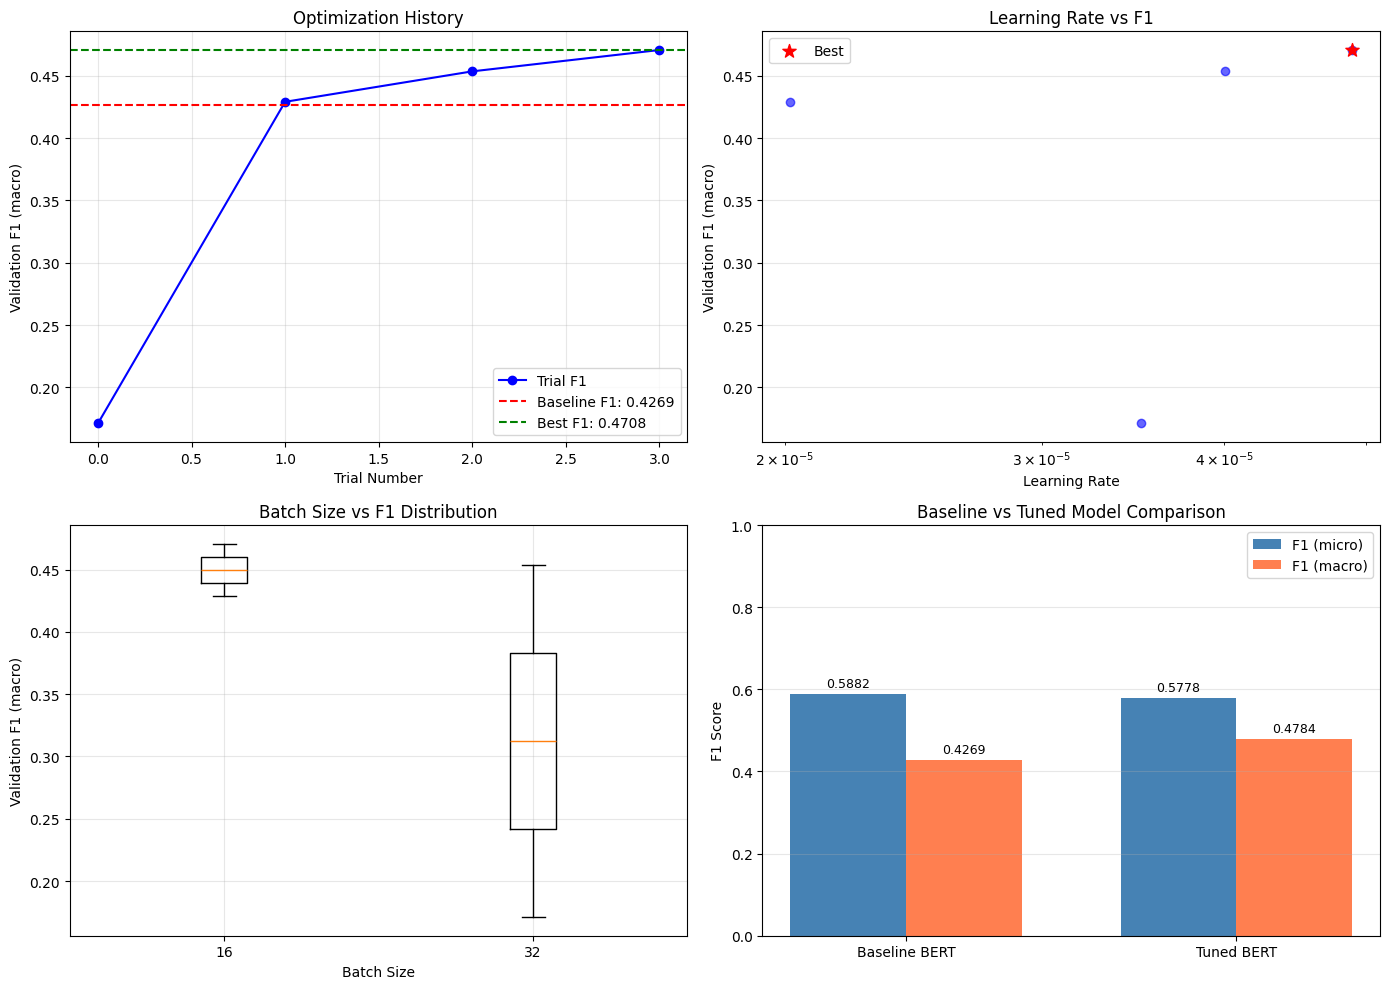


📊 Visualization saved to 'hyperparameter_tuning_results.png'


In [20]:
import matplotlib.pyplot as plt

# Create visualization of optimization history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Optimization History
ax1 = axes[0, 0]
trials_values = [t.value for t in study.trials if t.state == TrialState.COMPLETE]
ax1.plot(range(len(trials_values)), trials_values, 'bo-', label='Trial F1')
ax1.axhline(y=baseline_results['test_f1_macro'], color='r', linestyle='--', label=f'Baseline F1: {baseline_results["test_f1_macro"]:.4f}')
ax1.axhline(y=study.best_trial.value, color='g', linestyle='--', label=f'Best F1: {study.best_trial.value:.4f}')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Validation F1 (macro)')
ax1.set_title('Optimization History')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Learning Rate vs F1
ax2 = axes[0, 1]
lrs = [t.params['learning_rate'] for t in study.trials if t.state == TrialState.COMPLETE]
f1s = [t.value for t in study.trials if t.state == TrialState.COMPLETE]
ax2.scatter(lrs, f1s, c='blue', alpha=0.6)
ax2.scatter([best_lr], [study.best_trial.value], c='red', s=100, marker='*', label='Best')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Validation F1 (macro)')
ax2.set_title('Learning Rate vs F1')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Batch Size distribution
ax3 = axes[1, 0]
batch_sizes = [t.params['batch_size'] for t in study.trials if t.state == TrialState.COMPLETE]
batch_f1s = {}
for bs, f1 in zip(batch_sizes, f1s):
    if bs not in batch_f1s:
        batch_f1s[bs] = []
    batch_f1s[bs].append(f1)

batch_labels = sorted(batch_f1s.keys())
batch_values = [batch_f1s[bs] for bs in batch_labels]
ax3.boxplot(batch_values, labels=batch_labels)
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Validation F1 (macro)')
ax3.set_title('Batch Size vs F1 Distribution')
ax3.grid(True, alpha=0.3)

# 4. Comparison Bar Chart
ax4 = axes[1, 1]
models = ['Baseline BERT', 'Tuned BERT']
f1_micro_vals = [baseline_results['test_f1_micro'], tuned_test_results['f1_micro']]
f1_macro_vals = [baseline_results['test_f1_macro'], tuned_test_results['f1_macro']]

x = np.arange(len(models))
width = 0.35

bars1 = ax4.bar(x - width/2, f1_micro_vals, width, label='F1 (micro)', color='steelblue')
bars2 = ax4.bar(x + width/2, f1_macro_vals, width, label='F1 (macro)', color='coral')

ax4.set_ylabel('F1 Score')
ax4.set_title('Baseline vs Tuned Model Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(models)
ax4.legend()
ax4.set_ylim(0, 1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax4.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax4.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to 'hyperparameter_tuning_results.png'")

### Per-Class Performance Comparison
Compare the performance of both models on each emotion class.

Per-Class F1 Score Comparison (sorted by improvement):
         Label  Baseline F1  Tuned F1  Improvement
 embarrassment     0.000000  0.472727     0.472727
   nervousness     0.000000  0.303030     0.303030
disappointment     0.154762  0.317597     0.162835
         pride     0.000000  0.111111     0.111111
   realization     0.128205  0.239234     0.111029
     annoyance     0.254902  0.323887     0.068985
       sadness     0.536000  0.588997     0.052997
     confusion     0.390909  0.437710     0.046801
         anger     0.483384  0.520619     0.037235
        caring     0.409524  0.444444     0.034921
       disgust     0.440476  0.474419     0.033942
     curiosity     0.516484  0.548701     0.032218
        desire     0.466667  0.496454     0.029787
      surprise     0.536585  0.565371     0.028786
      optimism     0.535484  0.563380     0.027896
      approval     0.412451  0.434505     0.022053
   disapproval     0.361905  0.374245     0.012341
    excitement     0.402778

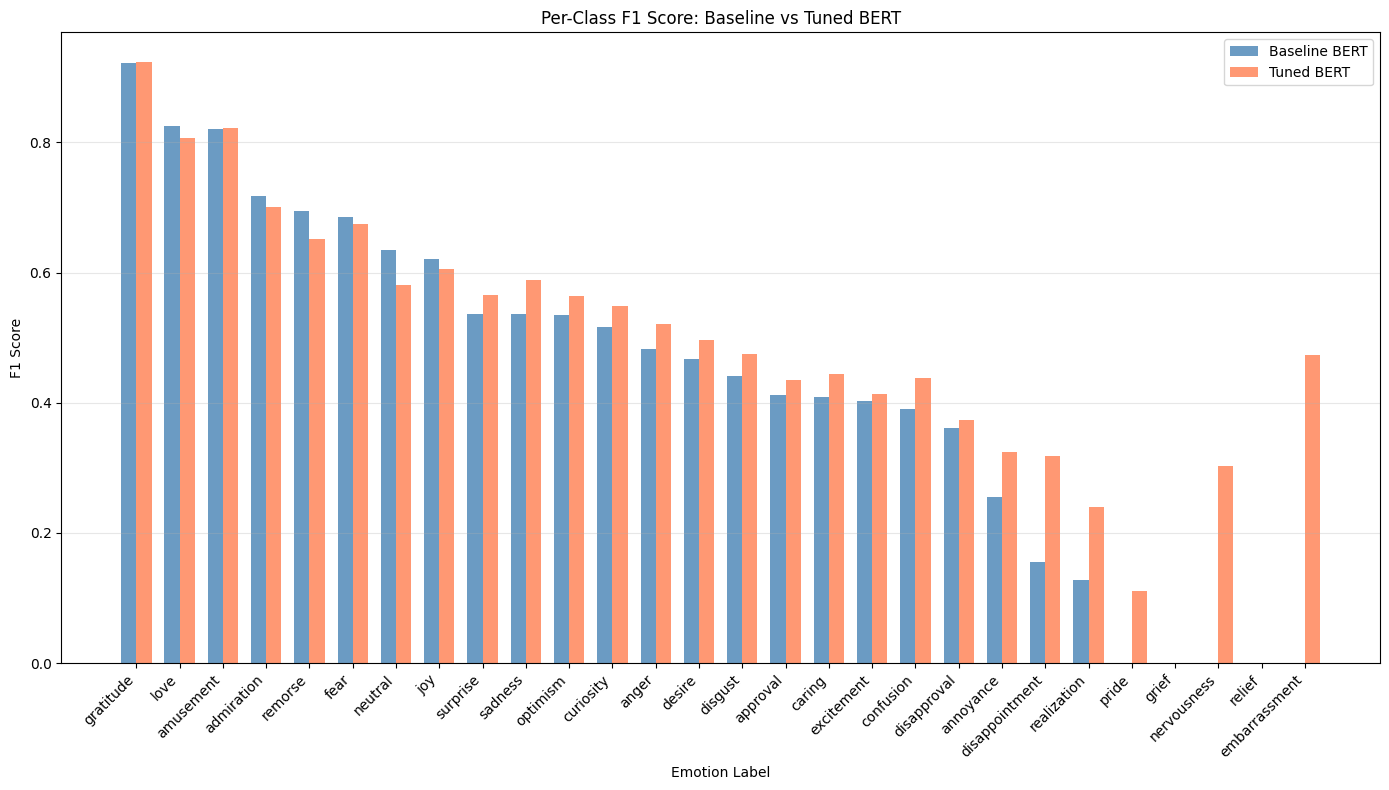


TOP 5 MOST IMPROVED CLASSES:
         Label  Baseline F1  Tuned F1  Improvement
 embarrassment     0.000000  0.472727     0.472727
   nervousness     0.000000  0.303030     0.303030
disappointment     0.154762  0.317597     0.162835
         pride     0.000000  0.111111     0.111111
   realization     0.128205  0.239234     0.111029

TOP 5 CLASSES WITH DECREASED PERFORMANCE:
     Label  Baseline F1  Tuned F1  Improvement
       joy     0.620209  0.605263    -0.014946
admiration     0.718408  0.701395    -0.017013
      love     0.824742  0.806387    -0.018355
   remorse     0.694215  0.651852    -0.042363
   neutral     0.635520  0.581173    -0.054347


In [21]:
# Calculate per-class F1 scores for both models
from sklearn.metrics import f1_score as sk_f1_score

# Get per-class F1 scores
baseline_per_class_f1 = sk_f1_score(
    test_results['labels'], 
    test_results['predictions'], 
    average=None, 
    zero_division=0
)

tuned_per_class_f1 = sk_f1_score(
    tuned_test_results['labels'], 
    tuned_test_results['predictions'], 
    average=None, 
    zero_division=0
)

# Create comparison DataFrame
per_class_comparison = pd.DataFrame({
    'Label': LABELS,
    'Baseline F1': baseline_per_class_f1,
    'Tuned F1': tuned_per_class_f1,
    'Improvement': tuned_per_class_f1 - baseline_per_class_f1
})
per_class_comparison = per_class_comparison.sort_values('Improvement', ascending=False)

print("Per-Class F1 Score Comparison (sorted by improvement):")
print("="*70)
print(per_class_comparison.to_string(index=False))

# Visualize per-class comparison
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(LABELS))
width = 0.35

# Sort by baseline F1 for better visualization
sorted_indices = np.argsort(baseline_per_class_f1)[::-1]
sorted_labels = [LABELS[i] for i in sorted_indices]
sorted_baseline = baseline_per_class_f1[sorted_indices]
sorted_tuned = tuned_per_class_f1[sorted_indices]

bars1 = ax.bar(x - width/2, sorted_baseline, width, label='Baseline BERT', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, sorted_tuned, width, label='Tuned BERT', color='coral', alpha=0.8)

ax.set_ylabel('F1 Score')
ax.set_xlabel('Emotion Label')
ax.set_title('Per-Class F1 Score: Baseline vs Tuned BERT')
ax.set_xticks(x)
ax.set_xticklabels(sorted_labels, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('per_class_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Show which classes improved most
print("\n" + "="*70)
print("TOP 5 MOST IMPROVED CLASSES:")
print("="*70)
print(per_class_comparison.head(5).to_string(index=False))

print("\n" + "="*70)
print("TOP 5 CLASSES WITH DECREASED PERFORMANCE:")
print("="*70)
print(per_class_comparison.tail(5).to_string(index=False))

### Save Final Results Summary

In [22]:
# Save comprehensive results to file
results_summary = {
    'baseline': {
        'hyperparameters': {
            'learning_rate': baseline_results['learning_rate'],
            'batch_size': baseline_results['batch_size'],
            'epochs': baseline_results['epochs'],
            'warmup_steps': baseline_results['warmup_steps'],
            'weight_decay': baseline_results['weight_decay'],
            'dropout': 0.1
        },
        'test_metrics': {
            'f1_micro': baseline_results['test_f1_micro'],
            'f1_macro': baseline_results['test_f1_macro'],
            'loss': baseline_results['test_loss']
        }
    },
    'tuned': {
        'hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch_size,
            'epochs': best_epochs,
            'warmup_ratio': best_warmup_ratio,
            'weight_decay': best_weight_decay,
            'dropout': best_dropout
        },
        'test_metrics': {
            'f1_micro': tuned_test_results['f1_micro'],
            'f1_macro': tuned_test_results['f1_macro'],
            'loss': tuned_test_results['loss']
        }
    },
    'improvement': {
        'f1_micro_pct': f1_micro_improvement,
        'f1_macro_pct': f1_macro_improvement,
        'loss_pct': loss_improvement
    },
    'optuna_study': {
        'n_trials': len(study.trials),
        'n_completed': len([t for t in study.trials if t.state == TrialState.COMPLETE]),
        'best_trial_number': study.best_trial.number,
        'best_val_f1': study.best_trial.value
    }
}

import json
with open('hyperparameter_tuning_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Save comparison DataFrame
comparison_df.to_csv('model_comparison.csv', index=False)
per_class_comparison.to_csv('per_class_comparison.csv', index=False)

print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"""
📊 Hyperparameter Tuning Complete!

BASELINE BERT MODEL:
  • Learning Rate: {baseline_results['learning_rate']}
  • Batch Size: {baseline_results['batch_size']}
  • Epochs: {baseline_results['epochs']}
  • Test F1 (micro): {baseline_results['test_f1_micro']:.4f}
  • Test F1 (macro): {baseline_results['test_f1_macro']:.4f}

TUNED BERT MODEL:
  • Learning Rate: {best_lr:.6f}
  • Batch Size: {best_batch_size}
  • Epochs: {best_epochs}
  • Warmup Ratio: {best_warmup_ratio:.4f}
  • Weight Decay: {best_weight_decay:.4f}
  • Dropout: {best_dropout:.4f}
  • Test F1 (micro): {tuned_test_results['f1_micro']:.4f}
  • Test F1 (macro): {tuned_test_results['f1_macro']:.4f}

IMPROVEMENT:
  • F1 (micro): {f1_micro_improvement:+.2f}%
  • F1 (macro): {f1_macro_improvement:+.2f}%

FILES SAVED:
  • best_tuned_bert_model.pt - Optimized model weights
  • hyperparameter_tuning_results.json - Full results summary
  • model_comparison.csv - Side-by-side comparison
  • per_class_comparison.csv - Per-class performance
  • hyperparameter_tuning_results.png - Visualization
  • per_class_comparison.png - Per-class visualization
""")

FINAL SUMMARY

📊 Hyperparameter Tuning Complete!

BASELINE BERT MODEL:
  • Learning Rate: 2e-05
  • Batch Size: 16
  • Epochs: 3
  • Test F1 (micro): 0.5882
  • Test F1 (macro): 0.4269

TUNED BERT MODEL:
  • Learning Rate: 0.000049
  • Batch Size: 16
  • Epochs: 5
  • Warmup Ratio: 0.1655
  • Weight Decay: 0.0348
  • Dropout: 0.2441
  • Test F1 (micro): 0.5778
  • Test F1 (macro): 0.4784

IMPROVEMENT:
  • F1 (micro): -1.77%
  • F1 (macro): +12.08%

FILES SAVED:
  • best_tuned_bert_model.pt - Optimized model weights
  • hyperparameter_tuning_results.json - Full results summary
  • model_comparison.csv - Side-by-side comparison
  • per_class_comparison.csv - Per-class performance
  • hyperparameter_tuning_results.png - Visualization
  • per_class_comparison.png - Per-class visualization



---
## Domain Adaptation: Fine-tune on Presidential Speeches
Now we will take our best tuned BERT model (trained on GoEmotions) and fine-tune it further on the labeled Presidential Speeches dataset. This adapts the model to the specific domain of political speech.

In [6]:
# Independent Setup for Domain Adaptation
import pandas as pd
import numpy as np
import torch
import json
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Labels
LABELS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]
NUM_LABELS = len(LABELS)

# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load Hyperparameters or set defaults
try:
    with open('hyperparameter_tuning_results.json', 'r') as f:
        results = json.load(f)
        best_params = results['tuned']['hyperparameters']
        best_batch_size = best_params['batch_size']
        best_dropout = best_params['dropout']
        best_weight_decay = best_params['weight_decay']
        print("Loaded best hyperparameters from file.")
except FileNotFoundError:
    print("Hyperparameter results file not found. Using defaults.")
    best_batch_size = 16
    best_dropout = 0.1
    best_weight_decay = 0.01

# Load Data
pres_df = pd.read_csv("data/presidential_speeches_goemotions_labeled.csv")
print(f"Presidential Dataset Shape: {pres_df.shape}")

# Identify text column (it might be 'Transcript', 'Speech', or 'text')
text_col = None
# Added 'speech' and other common variations to ensure we find the column
for col in ['speech', 'Speech', 'transcript', 'Transcript', 'text', 'Text', 'content']:
    if col in pres_df.columns:
        text_col = col
        break

if text_col is None:
    raise ValueError(f"Could not find text column. Available columns: {pres_df.columns.tolist()}")

print(f"Using text column: {text_col}")

# Verify all labels exist in the dataframe
missing_labels = [l for l in LABELS if l not in pres_df.columns]
if missing_labels:
    print(f"Warning: Missing labels in dataset: {missing_labels}")
else:
    print("All 28 emotion label columns found.")

# Display first few rows
pres_df[[text_col] + LABELS[:5]].head()

Using device: cuda
Loaded best hyperparameters from file.
Presidential Dataset Shape: (995, 67)
Using text column: speech
All 28 emotion label columns found.


,speech,admiration,amusement,anger,annoyance,approval
0,As long as I am President of the United States...,0,0,0,0,0
1,"Hello, everybody. Well, thank you very much. ...",0,0,0,0,0
2,"Last night, the United States brought the worl...",0,0,0,0,0
3,PRESIDENT TRUMP: Thank you very much. Thank...,0,0,0,0,0
4,PRESIDENT TRUMP: Thank you very much. Mr. ...,0,0,0,0,0


In [7]:
# Define necessary functions if running independently
def create_model_with_dropout(dropout_rate):
    """Create a BERT model with custom dropout rate."""
    config = BertConfig.from_pretrained(
        'bert-base-uncased',
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification",
        hidden_dropout_prob=dropout_rate,
        attention_probs_dropout_prob=dropout_rate
    )
    
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        config=config
    )
    return model

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            # Apply sigmoid and threshold
            probs = torch.sigmoid(outputs.logits)
            preds = (probs > threshold).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return {
        'loss': total_loss / len(dataloader),
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'predictions': all_preds,
        'labels': all_labels
    }

### Prepare Presidential Data
Split into train/test sets and create DataLoaders. We'll use a slightly larger max_length (256) since speeches tend to be longer.

In [8]:
# Train-test split (80% train, 20% test)
pres_train_df, pres_test_df = train_test_split(pres_df, test_size=0.2, random_state=42)

print(f"Presidential Train size: {len(pres_train_df)}")
print(f"Presidential Test size: {len(pres_test_df)}")

# Create Dataset class for Presidential data (handles different column names)
class PresidentialDataset(Dataset):
    def __init__(self, dataframe, tokenizer, text_col, max_length=256):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_col = text_col
        self.labels = LABELS
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = str(self.data.loc[idx, self.text_col])
        # Handle NaN or empty text
        if pd.isna(text):
            text = ""
            
        labels = self.data.loc[idx, self.labels].values.astype(float)
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Create datasets
pres_train_dataset = PresidentialDataset(pres_train_df, tokenizer, text_col)
pres_test_dataset = PresidentialDataset(pres_test_df, tokenizer, text_col)

# Create dataloaders
# Use the best batch size found during tuning
pres_train_loader = DataLoader(pres_train_dataset, batch_size=best_batch_size, shuffle=True)
pres_test_loader = DataLoader(pres_test_dataset, batch_size=best_batch_size)

print(f"Presidential training batches: {len(pres_train_loader)}")

Presidential Train size: 796
Presidential Test size: 199
Presidential training batches: 50


### Fine-tune Best Model on Presidential Data
We load the best model from the previous step and continue training on the presidential dataset. We'll use a lower learning rate to avoid catastrophic forgetting.

In [9]:
# Load the best tuned model
pres_model = create_model_with_dropout(best_dropout)
pres_model.load_state_dict(torch.load('best_tuned_bert_model.pt'))
pres_model.to(device)

# Hyperparameters for fine-tuning
# Use a smaller learning rate for fine-tuning
FINE_TUNE_LR = 1e-5
FINE_TUNE_EPOCHS = 3

optimizer = AdamW(pres_model.parameters(), lr=FINE_TUNE_LR, weight_decay=best_weight_decay)
total_steps = len(pres_train_loader) * FINE_TUNE_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Fine-tuning model on presidential data for {FINE_TUNE_EPOCHS} epochs...")

best_pres_f1 = 0

for epoch in range(FINE_TUNE_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{FINE_TUNE_EPOCHS}")
    print(f"{'='*50}")
    
    # Train
    train_loss = train_epoch(pres_model, pres_train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    # Evaluate on presidential test set
    val_results = evaluate(pres_model, pres_test_loader, device)
    print(f"Test Loss: {val_results['loss']:.4f}")
    print(f"Test F1 (micro): {val_results['f1_micro']:.4f}")
    print(f"Test F1 (macro): {val_results['f1_macro']:.4f}")
    
    # Save best model
    if val_results['f1_macro'] > best_pres_f1:
        best_pres_f1 = val_results['f1_macro']
        torch.save(pres_model.state_dict(), 'best_presidential_bert_model.pt')
        print("Saved best presidential model!")

print(f"\nBest Presidential Test F1 (macro): {best_pres_f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning model on presidential data for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Training Loss: 0.0629


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]
/home/xiang/miniconda3/envs/nlp/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Test Loss: 0.0633
Test F1 (micro): 0.5697
Test F1 (macro): 0.0397
Saved best presidential model!

Epoch 2/3


Training: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Training Loss: 0.0550


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
/home/xiang/miniconda3/envs/nlp/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Test Loss: 0.0581
Test F1 (micro): 0.6382
Test F1 (macro): 0.0427
Saved best presidential model!

Epoch 3/3


Training: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Training Loss: 0.0523


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

Test Loss: 0.0622
Test F1 (micro): 0.5600
Test F1 (macro): 0.0396

Best Presidential Test F1 (macro): 0.0427



/home/xiang/miniconda3/envs/nlp/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Final Evaluation on Presidential Dataset

In [11]:
# Load best presidential model
pres_model.load_state_dict(torch.load('best_presidential_bert_model.pt'))

final_results = evaluate(pres_model, pres_test_loader, device)

print("="*60)
print("FINAL PRESIDENTIAL MODEL RESULTS")
print("="*60)
print(f"Test Loss: {final_results['loss']:.4f}")
print(f"Test F1 (micro): {final_results['f1_micro']:.4f}")
print(f"Test F1 (macro): {final_results['f1_macro']:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(
    final_results['labels'], 
    final_results['predictions'], 
    target_names=LABELS,
    zero_division=0
))

Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]

FINAL PRESIDENTIAL MODEL RESULTS
Test Loss: 0.0581
Test F1 (micro): 0.6382
Test F1 (macro): 0.0427

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00         3
     amusement       0.00      0.00      0.00         0
         anger       0.00      0.00      0.00         0
     annoyance       0.00      0.00      0.00         0
      approval       0.67      0.06      0.10        36
        caring       0.00      0.00      0.00         1
     confusion       0.00      0.00      0.00         0
     curiosity       0.00      0.00      0.00         1
        desire       0.00      0.00      0.00         2
disappointment       0.00      0.00      0.00         0
   disapproval       0.00      0.00      0.00         0
       disgust       0.00      0.00      0.00         0
 embarrassment       0.00      0.00      0.00         0
    excitement       0.00      0.00      0.00         0
          fear       0.00  


/home/xiang/miniconda3/envs/nlp/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
